# Script for masterthesis
### This script demonstrates what we have done to get the output used in this thesis. 
### The script shows an example of Saurdal and if you want to see another power plant, change power plant specific variables where it is specified


In [1]:
# Importing relevant packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from scipy import stats

# Setting correct working directory
path = 'C:/Users/Henrik/Dropbox/NMBU/Masterthesis/Data/cleaned' # Change to the directory where the dataset is located
os.chdir(path)

# Obtaining the dataset
df = pd.DataFrame(pd.read_csv('./df.csv', index_col = 'time', parse_dates=[0]))

# Setting correct time index
df = df[(df.index >= '2021-08-01 00:00:00') & (df.index <= '2021-12-31 23:00:00')]


### Transformations

In [35]:
def f(df):
    if df['Saurdal'] > 5: # Change to other power plant
        val = 1
    elif df['Saurdal'] <= 5: # Change to other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2']) # Change to no5 if you are using a power plant in this price area
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # Change to other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # Change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # Change to bergen

### Double-censored regression model and visualization of latent water value with relevant variables


This is the interval censored model (structural parameters)

          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:41:57
Dependent variable      :          lnP_no2
Number of observations  :             3672
  Left-censored         :              756
  Right-censored        :             2916
Number of regressors    :                8
Number of iterations    :                6
Run time (s)            :            0.031
Log-likelihood value    :        -1458.224
Variable            est coeff      std err
------------------------------------------
LnCs                 0.449572     0.205869
lnTtf               -0.770841     0.109070
logdfill_Saurdal    -2.620517     0.257070
lnTemp_kristians    -0.271830     0.031688
lnTemp_stavanger     0.004796     0.027097
lnDfill_gas          0.977102     0.165393
const               12.270568     1.932764
------------------------------------------
sigma               -0.400687     0

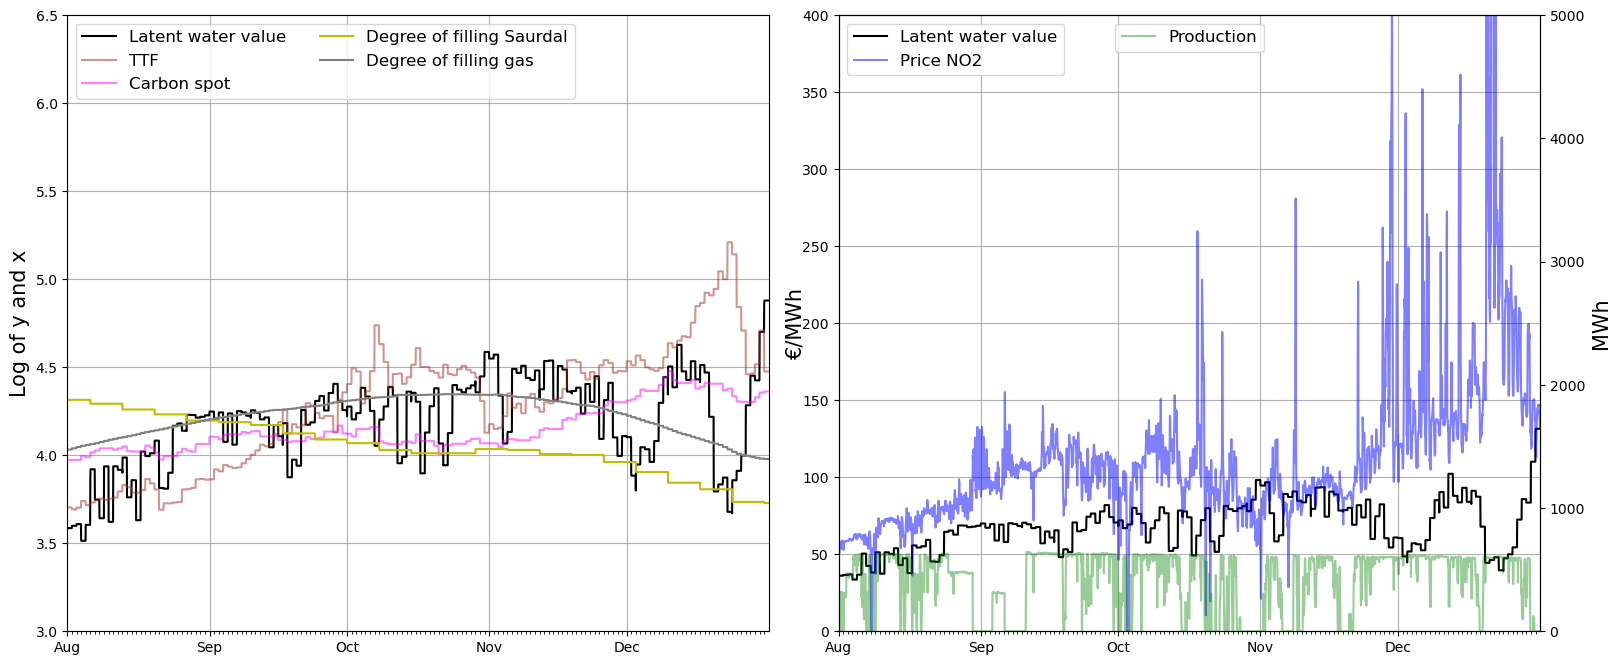

In [36]:

# Importing downloaded package
sys.path.insert(0, 'C:/Users/Henrik/Dropbox/NMBU/Masterthesis/Code/PythonPackage/intreg-20230218T101401Z-001/intreg/') # Change to the directory where the package is located
import RegModels

df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['LnCs', 'lnTtf', 'logdfill_Saurdal', 'lnTemp_kristiansand', 'lnTemp_stavanger', 'lnDfill_gas', 'const'] # change to power plant and price area specific variables
xvars = df[x_cols].values

c_col = ['lnP_no2'] # Change to no5
cvar  = df[c_col].values

# Double censored regression model
pm = RegModels.DCensReg(yvar,cvar,xvars)
pm.set_xlabel(c_col,x_cols)
pm.set_ylabel('accept')
rc = pm.fit()
if rc!=0:
    sys.exit('Maximum likelihood estimate not found')

print()
print('This is the interval censored model (structural parameters)')
print()
pm.print_struct_params()

# predictions
beta, sigma = pm.get_struct_params()
df['Lat_wv_Saurdal'] = np.dot(xvars,beta) # change to the name of other power plant

# converting the latent water value to €/MWh
df['res_price_Saurdal'] = df['Lat_wv_Saurdal'].apply(lambda x: math.exp(x)) # change to the name of other power plant

# Graph
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8))
fig = plt.gcf()

axs[0].plot(df['Lat_wv_Saurdal'], 'k', label='Latent water value') # change to the name of other power plant
axs[0].plot(df['lnTtf'], 'brown', alpha=0.5, label='TTF')
axs[0].plot(df['LnCs'], 'magenta', alpha=0.5, label='Carbon spot')
axs[0].plot(df['logdfill_Saurdal'], 'y', label='Degree of filling Saurdal') # change to the name of other power plant
axs[0].plot(df['lnDfill_gas'], 'grey', label='Degree of filling gas')
axs[0].set_ylim(3, 6.5)
axs[0].legend(loc='upper left', fontsize=12, ncol=2)
axs[0].grid()
axs[0].set_title('', fontsize=14)
axs[0].set_ylabel('Log of y and x', fontsize=15)

axs[1].plot(df['res_price_Saurdal'], 'k', label='Latent water value') # change to the name of other power plant
axs[1].plot(df['NO2'], 'b', alpha=0.5, label='Price NO2')
axs[1].set_ylim(0, 400)
axs[1].set_ylabel('€/MWh', fontsize=15, labelpad=-2)
axs[1].legend(loc='upper left', fontsize=12)
axs[1].grid()

ax2 = axs[1].twinx()
ax2.plot(df['Saurdal'], 'g', alpha=0.4, label='Production') # Change to no5
ax2.set_ylim(0, 5000)
ax2.set_ylabel('MWh', fontsize=15)
ax2.legend(loc='upper center', fontsize=12)
axs[1].set_title('', fontsize=14)

# share the x-axis between subplots and adjusting labels
for ax in axs:
    ax.set_xlim(df.index.min(), df.index.max())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.subplots_adjust(wspace=0.1)
plt.show()

### Parameters and coefficients

In [37]:
params = pm.get_struct_params()
arr = params[0]

#Standard error
v = np.sqrt(np.diagonal(pm.get_struct_vcov()))

# Calculating z and p-values from the parameter-array. Need the z values to calculating p-values
def estimates(arr, v):
    z = np.array([arr[i] / v[i] for i in range(len(arr))])
    p_values = np.array([stats.norm.sf(abs(z[i])) * 2 for i in range(len(z))])
    return z, p_values

z, p_values = estimates(arr, v)

print()
print('             Double Censored Regression Model\n')
print('Variable              Est Coef  Std Err     z       P>|z|')
print('----------------------------------------------------------')
print('LnCs                 %8.4f %8.4f %8.2f %8.2f' % (arr[0], v[0], z[0], p_values[0]))
print('lnTtf                %8.4f %8.4f %8.2f %8.2f' % (arr[1], v[1], z[1], p_values[1]))
print('lnDfill_Saurdal      %8.4f %8.4f %8.2f %8.2f' % (arr[2], v[2], z[2], p_values[2])) # change name of other power plant
print('lnDfill_gas          %8.4f %8.4f %8.2f %8.2f' % (arr[5], v[5], z[5], p_values[5]))
print('lnTemp_kristiansand  %8.4f %8.4f %8.2f %8.2f' % (arr[3], v[3], z[3], p_values[3])) # change to price area specific variables
print('lnTemp_stavanger     %8.4f %8.4f %8.2f %8.2f' % (arr[4], v[4], z[4], p_values[4])) # change to price area specific variables
print('const                %8.4f %8.4f %8.2f %8.2f' % (arr[6], v[6], z[6], p_values[6]))
print('----------------------------------------------------------')


             Double Censored Regression Model

Variable              Est Coef  Std Err     z       P>|z|
----------------------------------------------------------
LnCs                   0.4496   0.2059     2.18     0.03
lnTtf                 -0.7708   0.1091    -7.07     0.00
lnDfill_Saurdal       -2.6205   0.2571   -10.19     0.00
lnDfill_gas            0.9771   0.1654     5.91     0.00
lnTemp_kristiansand   -0.2718   0.0317    -8.58     0.00
lnTemp_stavanger       0.0048   0.0271     0.18     0.86
const                 12.2706   1.9328     6.35     0.00
----------------------------------------------------------


### Goodness of fit

In [38]:

df['production_below_5MW'] = df['Saurdal'] <= 5 # Change power station
df['value_below_threshold'] = df['lnP_no2'] < df['Lat_wv_Saurdal'] # change price area and power station
df['conditions_met'] = (df['production_below_5MW'] & df['value_below_threshold']) | (~df['production_below_5MW'] & ~df['value_below_threshold'])
percentage_fit = df['conditions_met'].mean() * 100
print(f"Percentage of fit: {percentage_fit:.2f}%")


Percentage of fit: 84.72%


### Assumptions

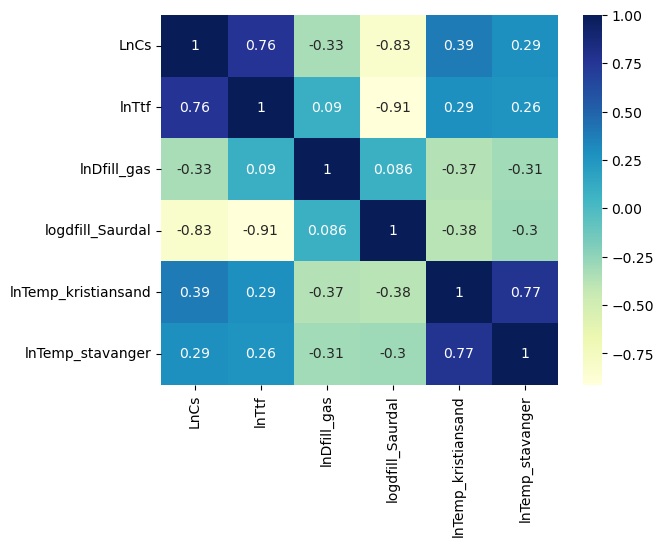

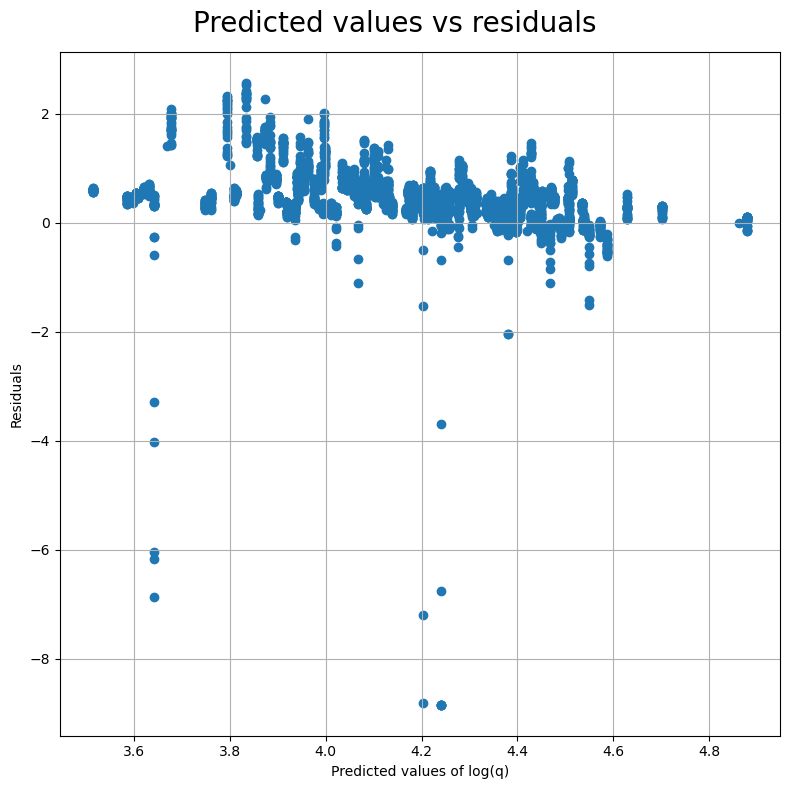

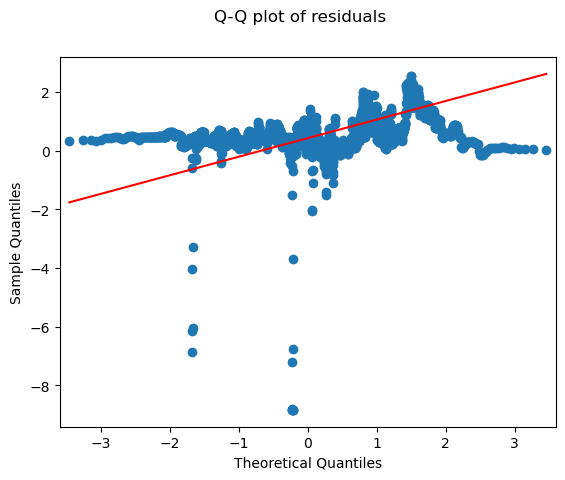

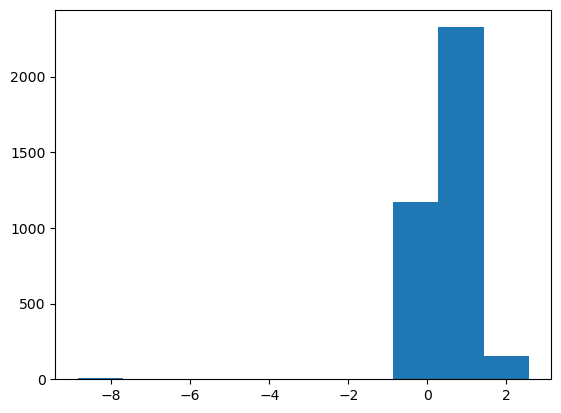

In [39]:

# 1. Correlation nmatrix

variables = ["LnCs", "lnTtf", "lnDfill_gas", "logdfill_Saurdal", "lnTemp_kristiansand", "lnTemp_stavanger"] # change to power plant and price area specific variables
corr_matrix = df[variables].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


# 2. IID
fitted_values = pm.yhat()
residuals = cvar - fitted_values

# Predicted vs residuals
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Predicted values vs residuals", fontsize = 20)
ax.scatter(fitted_values, residuals)
ax.set_xlabel('Predicted values of log(q)')
ax.set_ylabel('Residuals')
ax.grid(True)
fig.tight_layout()

# Q-Q plot
fig = sm.qqplot(residuals, line='s')
fig.suptitle("Q-Q plot of residuals")
plt.show()

# Histogram of the residuals
plt.hist(residuals, bins=10)
plt.show()

### Finding structural breaks using rolling window approach
### Estimating first 6 week, 5 weeks then 4 weeks. 

          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:23
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  Right-censored        :             3963
Number of regressors    :                2
Number of iterations    :                5
Run time (s)            :            0.000
Log-likelihood value    :        -2504.543
Variable            est coeff      std err
------------------------------------------
const                3.689521     0.040408
------------------------------------------
sigma               -0.934652     0.049476

None
(array([[3.68952052]]), array([-0.93465215]))
          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:25
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  

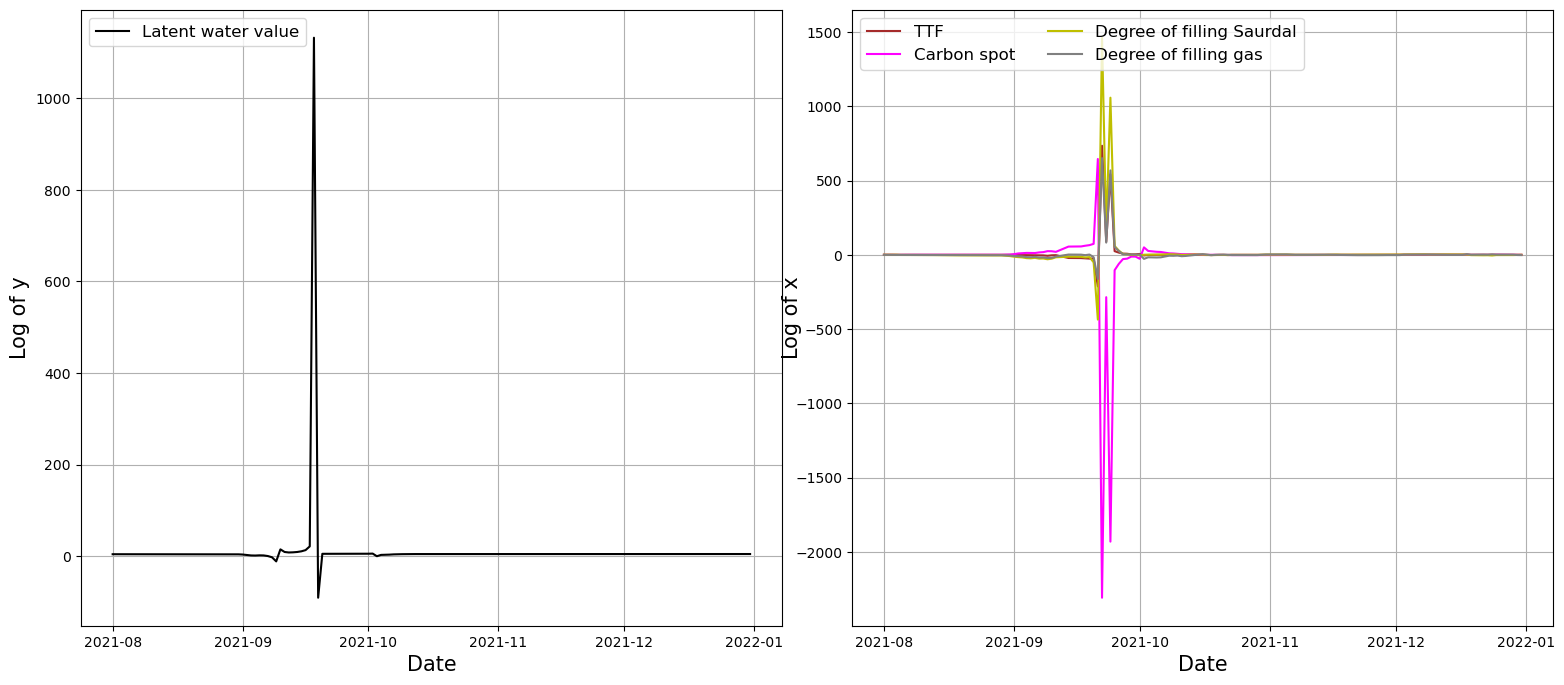

In [40]:
# Setting correct workingdirectory
path = 'C:/Users/Henrik/Dropbox/NMBU/Masterthesis/Data/cleaned'
os.chdir(path)

# Obtaining the dataset
df = pd.DataFrame(pd.read_csv('./df.csv', index_col = 'time', parse_dates=[0]))

# Setting correct time index
df = df[(df.index >= '2021-06-01 00:00:00') & (df.index <= '2021-12-31 23:00:00')]

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2']) # change price area 
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['const']
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-1008:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()
dr = dr.set_index('date').sort_index()

# creating an empty dataframe with column names
df2 = pd.DataFrame(columns=['const'])

# setting a new column in df2 from a column in df1
df2['const'] = dr['const']

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2'])
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['LnCs', 'lnTtf', 'logdfill_Saurdal', 'lnDfill_gas', 'const'] # change to the name of other power plant
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-1008:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()

dr = dr.set_index('date').sort_index()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8), sharex=True)
fig = plt.gcf()

axs[0].plot(df2['const'], 'k', label='Latent water value')
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_ylabel('Log of y', fontsize=15)
axs[0].set_xlabel('Date', fontsize=15)
axs[0].grid(True)

axs[1].plot(dr['lnTtf'], 'brown', label='TTF')
axs[1].plot(dr['LnCs'], 'magenta', label='Carbon spot')
axs[1].plot(dr['logdfill_Saurdal'], 'y', label='Degree of filling Saurdal') # change to the name of other power plant
axs[1].plot(dr['lnDfill_gas'], 'grey', label='Degree of filling gas')
axs[1].legend(loc='upper left', fontsize=12, ncol=2)
axs[1].grid(True)
axs[1].set_title('', fontsize=14)
axs[1].set_ylabel('Log of x', fontsize=15, labelpad=-5)
axs[1].set_xlabel('Date', fontsize=15)

fig.subplots_adjust(wspace=0.1)
plt.show()

### 5 Weeks

          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:30
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  Right-censored        :             3963
Number of regressors    :                2
Number of iterations    :                5
Run time (s)            :            0.000
Log-likelihood value    :        -2504.543
Variable            est coeff      std err
------------------------------------------
const                3.689521     0.040408
------------------------------------------
sigma               -0.934652     0.049476

None
(array([[3.68952052]]), array([-0.93465215]))
          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:32
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  

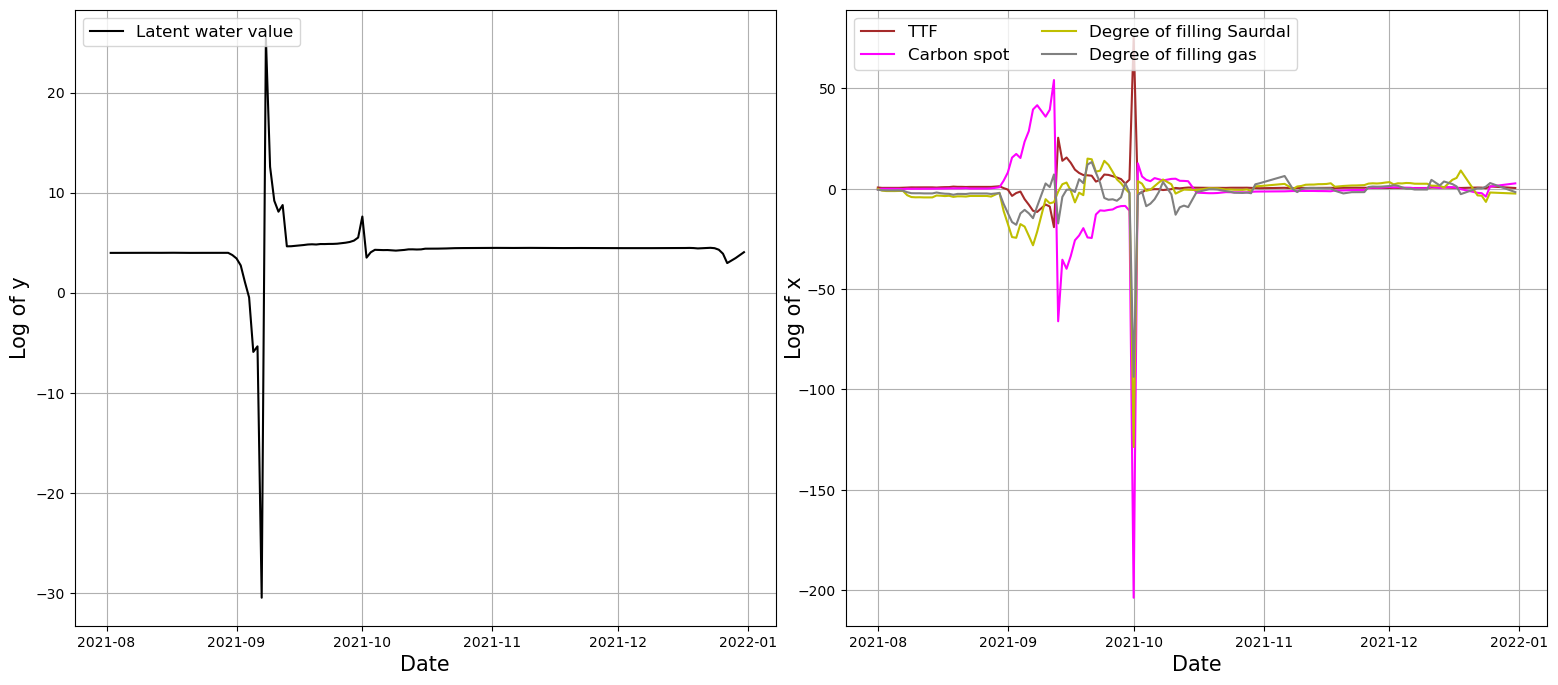

In [41]:
# Obtaining the dataset
df = pd.DataFrame(pd.read_csv('./df.csv', index_col = 'time', parse_dates=[0]))

# Setting correct time index
df = df[(df.index >= '2021-06-01 00:00:00') & (df.index <= '2021-12-31 23:00:00')]

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2']) # change price area 
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['const']
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-840:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()
dr = dr.set_index('date').sort_index()

# creating an empty dataframe with column names
df2 = pd.DataFrame(columns=['const'])

# setting a new column in df2 from a column in df1
df2['const'] = dr['const']

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2'])
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['LnCs', 'lnTtf', 'logdfill_Saurdal', 'lnDfill_gas', 'const'] # change to the name of other power plant
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-840:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()

dr = dr.set_index('date').sort_index()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8), sharex=True)
fig = plt.gcf()

axs[0].plot(df2['const'], 'k', label='Latent water value')
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_ylabel('Log of y', fontsize=15)
axs[0].set_xlabel('Date', fontsize=15)
axs[0].grid(True)

axs[1].plot(dr['lnTtf'], 'brown', label='TTF')
axs[1].plot(dr['LnCs'], 'magenta', label='Carbon spot')
axs[1].plot(dr['logdfill_Saurdal'], 'y', label='Degree of filling Saurdal') # change to the name of other power plant
axs[1].plot(dr['lnDfill_gas'], 'grey', label='Degree of filling gas')
axs[1].legend(loc='upper left', fontsize=12, ncol=2)
axs[1].grid(True)
axs[1].set_title('', fontsize=14)
axs[1].set_ylabel('Log of x', fontsize=15, labelpad=-5)
axs[1].set_xlabel('Date', fontsize=15)

fig.subplots_adjust(wspace=0.1)
plt.show()

### 4 Weeks

          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:41
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  Right-censored        :             3963
Number of regressors    :                2
Number of iterations    :                5
Run time (s)            :            0.015
Log-likelihood value    :        -2504.543
Variable            est coeff      std err
------------------------------------------
const                3.689521     0.040408
------------------------------------------
sigma               -0.934652     0.049476

None
(array([[3.68952052]]), array([-0.93465215]))
          Double Censored Regression Model
Date                    :       11.05.2023
Time                    :         10:42:43
Dependent variable      :          lnP_no2
Number of observations  :             5136
  Left-censored         :             1173
  

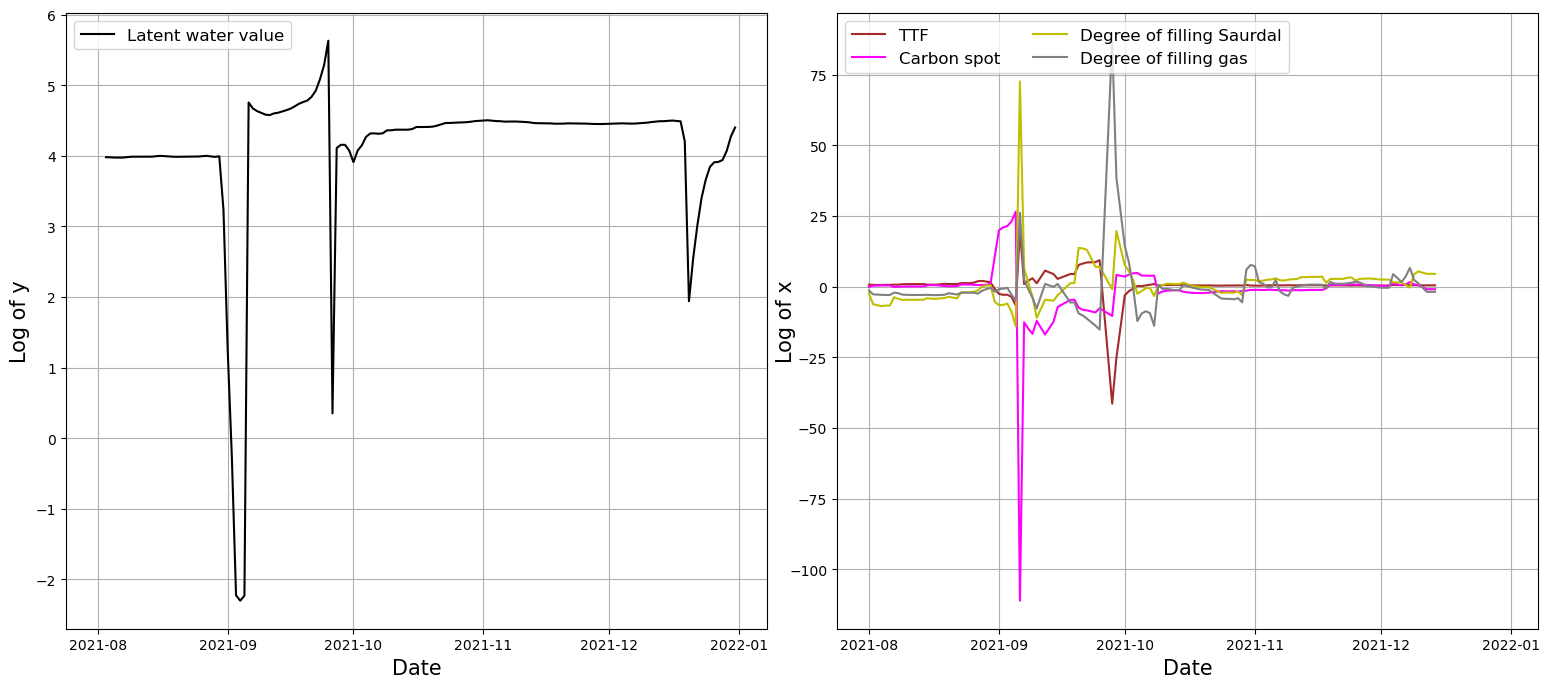

In [42]:
# Obtaining the dataset
df = pd.DataFrame(pd.read_csv('./df.csv', index_col = 'time', parse_dates=[0]))

# Setting correct time index
df = df[(df.index >= '2021-06-01 00:00:00') & (df.index <= '2021-12-31 23:00:00')]

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2']) # change price area 
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['const']
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-672:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()
dr = dr.set_index('date').sort_index()

# creating an empty dataframe with column names
df2 = pd.DataFrame(columns=['const'])

# setting a new column in df2 from a column in df1
df2['const'] = dr['const']

def f(df):
    if df['Saurdal'] > 5: # change to the name of other power plant
        val = 1
    elif df['Saurdal'] <= 5: # change to the name of other power plant
        val = 0
    else:
        val = -1
    return val

df['resp'] = df.apply(f, axis=1)
df['LnCs'] = np.log(df['Carbon'])
df['lnTtf'] = np.log(df['TTF'])
df['lnP_no2'] = np.log(df['NO2'])
df['lnDfill_gas'] = np.log(df['Gas_storage'])
df['logdfill_Saurdal'] = np.log(df['lag_dfill_Saurdal']) # change to the name of other power plant
df['lnTemp_kristiansand'] = np.log(df['temp_diff_krs'] + 1) # change to voss
df['lnTemp_stavanger'] = np.log(df['temp_diff_svg'] + 1) # change to bergen
df['const'] = 1.0

y_col = ['resp']
yvar = df[y_col].values

x_cols = ['LnCs', 'lnTtf', 'logdfill_Saurdal', 'lnDfill_gas', 'const'] # change to the name of other power plant
xvars = df[x_cols].values

c_col = ['lnP_no2'] # change price area
cvar  = df[c_col].values

def ireg(data,ycol,ccol,xcols,flag=False):


    xv = data[xcols].values
    yv = data[ycol].values
    cv = data[ccol].values
    
    pm = RegModels.DCensReg(yv,cv,xv)
    pm.set_xlabel(ccol,xcols)
    pm.set_ylabel('accept')
    rc = pm.fit()
    if rc!=0:
        return None
    if flag:
        print(pm.print_struct_params())
    
    return pm.get_struct_params()

beta = ireg(df,y_col,c_col,x_cols,True)
print(beta)


dr = pd.DataFrame(columns=x_cols)
ds = pd.DataFrame(columns=['sigma'])
dd = pd.DataFrame(columns=['date'])

df = df.reset_index()

for i in range(1464,len(df.index),24):
    beta = ireg(df.iloc[i-672:i,:],y_col,c_col,x_cols) #1008 #840 #672
    if beta is not None:
#print(beta)
        dd.loc[len(dd.index)] = df.iloc[i]['time']
        dr.loc[len(dr.index)] = beta[0][:,0].tolist()
        ds.loc[len(ds.index)] = beta[1].tolist()


dr = dr.join(ds.join(dd))
dr.tail()

dr = dr.set_index('date').sort_index()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(19, 8), sharex=True)
fig = plt.gcf()

axs[0].plot(df2['const'], 'k', label='Latent water value')
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_ylabel('Log of y', fontsize=15)
axs[0].set_xlabel('Date', fontsize=15)
axs[0].grid(True)

axs[1].plot(dr['lnTtf'], 'brown', label='TTF')
axs[1].plot(dr['LnCs'], 'magenta', label='Carbon spot')
axs[1].plot(dr['logdfill_Saurdal'], 'y', label='Degree of filling Saurdal') # change to the name of other power plant
axs[1].plot(dr['lnDfill_gas'], 'grey', label='Degree of filling gas')
axs[1].legend(loc='upper left', fontsize=12, ncol=2)
axs[1].grid(True)
axs[1].set_title('', fontsize=14)
axs[1].set_ylabel('Log of x', fontsize=15, labelpad=-5)
axs[1].set_xlabel('Date', fontsize=15)

fig.subplots_adjust(wspace=0.1)
plt.show()